# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [116]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [117]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [118]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [119]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [120]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [121]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [122]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [123]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [124]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation.csv.gz')
data.shape

(200000, 79)

In [125]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,hemiplegia_comor,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1210,695,40,40,40,13,13,1210,1210,1210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-07-05,2022-04-15,2020-07,2021-06,2020-06,2018-03,2018-12,2021-03-18,2021-02-17,2020-07-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,19,178,4012,556,559,1761,1724,72,29,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.994194e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.767260e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000372e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.982130e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500024e+06


### 1-2- Additional variables
#### 1-2-1- Calculating CHarlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [128]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [129]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    # if data.iat[idx, col4] == 1: # heart_failure_comor############################
    #     n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia#########################################
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma#########################################
    #    n=n+2

    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3

    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     26364
3.0     25753
4.0     23906
1.0     23588
0.0     18937
5.0     17597
6.0     15866
7.0     12473
8.0      9665
9.0      7628
10.0     6092
11.0     4177
12.0     2985
13.0     1933
14.0     1197
15.0      726
16.0      513
17.0      270
18.0      157
19.0       95
20.0       40
21.0       27
22.0        5
23.0        4
24.0        2
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [130]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    132877
2     22597
3     18600
1     17481
4      7275
5      1105
6        65
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [131]:
#dropping any variable with more than 50 percent missing values
perc = 50.0
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
data.shape

(200000, 82)

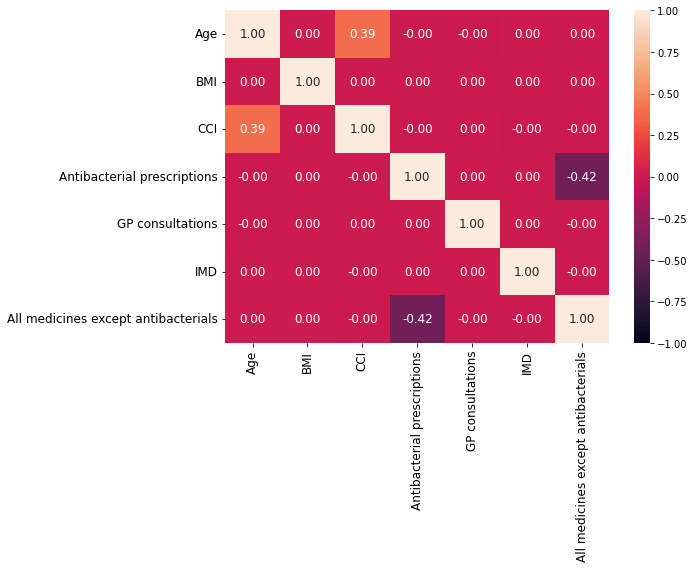

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [133]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = 0

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [134]:
# dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

# data = data.replace({"sex": dict_sex})
data = data.replace({"smoking_status": dict_smoking})

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti10.jpg')
plt.show()

In [135]:
if ('bmi' in data.columns) and (data['bmi'].isnull().sum() > 0):
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    # imputer.fit(data[['age', 'sex', 'bmi']])
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])# 'CCI']])
    # data['bmi_imp'] = np.nan
    # data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'bmi']]))[:,2]
    data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]
elif ('bmi' in data.columns) and (data['bmi'].isnull().sum() == 0):
    data['bmi_imp'] = data['bmi']

# 
print(f'Count of missing values in variable bmi: {data.bmi.isnull().sum()}')
print(f'Mean of bmi values: {data.bmi.mean():.3f}')
print(f'Max of bmi values: {data.bmi.max():.3f}')
print(f'Min of bmi values: {data.bmi.min():.3f}')
print(f'Count of missing values in variable bmi after imputation: {data.bmi_imp.isnull().sum()}')
print(f'Mean of bmi values after imputation: {data.bmi_imp.mean():.3f}')
print(f'Max of bmi values after imputation: {data.bmi_imp.max():.3f}')
print(f'Min of bmi values after imputation: {data.bmi_imp.min():.3f}')

Count of missing values in variable bmi: 0
Mean of bmi values: 26.241
Max of bmi values: 78.844
Min of bmi values: 0.000
Count of missing values in variable bmi after imputation: 0
Mean of bmi values after imputation: 26.241
Max of bmi values after imputation: 78.844
Min of bmi values after imputation: 0.000


In [136]:
if ('imd' in data.columns) and (data['imd'].isnull().sum() > 0):
    data['imd'] = data['imd'].astype(str)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    imputer.fit(data[['age', 'sex', 'CCI', 'imd']])#'bmi_imp']])
    # data['imd_imp'] = np.nan
    data['imd_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'imd']]))[:,3]
    # data['imd_imp'] = data['imd_imp'].astype(str)
elif ('imd' in data.columns) and (data['imd'].isnull().sum() == 0):
    data['imd_imp'] = data['imd']
    # data['imd_imp'] = data['imd_imp'].astype(str)

print(f'Cound of missing values in variable imd: {data.imd.isnull().sum()}')
print(f'Count of categories of variable imd: \n{data.imd.value_counts()}')
print(f'\nCound of missing values in variable imd after imputation: {data.imd_imp.isnull().sum()}')
print(f'Count of categories of variable imd after imputation: \n{data.imd_imp.value_counts()}')

Cound of missing values in variable imd: 0
Count of categories of variable imd: 
1    38482
4    38199
5    38014
2    37732
3    37698
0     9875
Name: imd, dtype: int64

Cound of missing values in variable imd after imputation: 0
Count of categories of variable imd after imputation: 
1    38482
4    38199
5    38014
2    37732
3    37698
0     9875
Name: imd_imp, dtype: int64


In [99]:
# dict_smoking_status = {'S':'1', 'N':2, 'E':3, 'M':4}
# data = data.replace({"smoking_status": dict_smoking_status})

In [139]:
# if ('smoking_status' in data.columns) and ((data['smoking_status'].isnull().sum() > 0) or (int(data['smoking_status'].loc[data['smoking_status']=='nan'].agg(['count']))>0)):
if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
    data['smoking_status'] = data['smoking_status'].astype(str)
    # data['smoking_status_imp'] = data['smoking_status'].replace(np.nan, 0)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']])#'imd']]) # 'imd_imp'
    # data['smoking_status_imp'] = np.nan
    data['smoking_status_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']]))[:,4]
    # data['smoking_status_imp'] = data['smoking_status_imp'].astype(str)
elif ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() == 0):
    data['smoking_status_imp'] = data['smoking_status']
    # data['smoking_status_imp'] = data['smoking_status_imp'].astype(str)

print(f'Cound of missing values in variable smoking_status: {data.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status: \n{data.smoking_status.value_counts()}')
print(f'\nCound of missing values in variable smoking_status after imputation: {data.smoking_status_imp.isnull().sum()}')
print(f'Count of categories of variable smoking_status after imputation: \n{data.smoking_status_imp.value_counts()}')

Cound of missing values in variable smoking_status: 83028
Count of categories of variable smoking_status: 
1.0    77696
3.0    26236
2.0    13040
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after imputation: 0
Count of categories of variable smoking_status after imputation: 
2.0    96068
1.0    77696
3.0    26236
Name: smoking_status_imp, dtype: int64


In [96]:
# # if ('ethnicity' in data.columns) and ((data['ethnicity'].isnull().sum() > 0) or (int(data['ethnicity'].loc[data['ethnicity']=='nan'].agg(['count']))>0)):
# if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
#     data['ethnicity'] = data['ethnicity'].astype(str)
#     # data['ethnicity_imp'] = data['ethnicity'].replace(np.nan, 0)
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']])
#     # data['ethnicity_imp'] = np.nan
#     data['ethnicity_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']]))[:,5] #'imd_imp'
#     # data['ethnicity_imp'] = data['ethnicity_imp'].astype(str)
# elif ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() == 0):
#     data['ethnicity_imp'] = data['ethnicity']
#     # data['ethnicity_imp'] = data['ethnicity_imp'].astype(str)

# print(f'Cound of missing values in variable ethnicity: {data.ethnicity.isnull().sum()}')
# print(f'Count of categories of variable ethnicity: \n{data.ethnicity.value_counts()}')
# print(f'\nCound of missing values in variable ethnicity after imputation: {data.ethnicity_imp.isnull().sum()}')
# print(f'Count of categories of variable ethnicity after imputation: \n{data.ethnicity_imp.value_counts()}')

Cound of missing values in variable ethnicity: 0
Count of categories of variable ethnicity: 
1.0    119911
nan     50000
5.0     15129
3.0     14960
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after imputation: 0
Count of categories of variable ethnicity after imputation: 
1.0    119911
2.0     50000
5.0     15129
3.0     14960
Name: ethnicity_imp, dtype: int64


In [105]:
if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
    # # iterative imputation with sklearn package
    # imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    # imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']])# 'ethnicity_imp']]) # 'imd_imp'
    # # data['gp_count_imp'] = np.nan
    # data['gp_count_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'gp_count']]))[:,3] #'imd_imp'
    # drop gp_count value missing
    data['gp_count_imp'] = data['gp_count']
    data = data[data['gp_count_imp'].notna()]
elif ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() == 0):
    data['gp_count_imp'] = data['gp_count']

print(f'Cound of missing values in variable gp_count: {data.gp_count.isnull().sum()}')
print(f'Mean of gp_count values: {data.gp_count.mean():.3f}')
print(f'\nCound of missing values in variable gp_count after imputation: {data.gp_count_imp.isnull().sum()}')
print(f'Mean of gp_count values after imputation: {data.gp_count_imp.mean():.3f}')

Cound of missing values in variable gp_count: 0
Mean of gp_count values: 3.312

Cound of missing values in variable gp_count after imputation: 0
Mean of gp_count values after imputation: 3.312


In [106]:
if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']])# 'gp_count']]) #'imd_imp'
#     # data['antibacterial_brit_imp'] = np.nan
#     data['antibacterial_brit_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']]))[:,7] # 'imd_imp'
    # drop antibacterial_brit value missing
    data['antibacterial_brit_imp'] = data['antibacterial_brit']
    data = data[data['antibacterial_brit_imp'].notna()]
elif ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() == 0):
    data['antibacterial_brit_imp'] = data['antibacterial_brit']

print(f'Cound of missing values in variable antibacterial_brit: {data.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values: {data.antibacterial_brit.mean():.3f}')
print(f'\nCound of missing values in variable antibacterial_brit after imputation: {data.antibacterial_brit_imp.isnull().sum()}')
print(f'Mean of antibacterial_brit values after imputation: {data.antibacterial_brit_imp.mean():.3f}')

Cound of missing values in variable antibacterial_brit: 0
Mean of antibacterial_brit values: 1.251

Cound of missing values in variable antibacterial_brit after imputation: 0
Mean of antibacterial_brit values after imputation: 1.251


In [61]:
if ('region' in data.columns) and (data['region'].isnull().sum() > 0):
#     # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']])
#     # data['region_imp'] = np.nan
#     data['region_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']]))[:,7] # 'imd_imp'
    # drop region value missing
    data['region_imp'] = data['region']
    data = data[data['region_imp'].notna()]
elif ('region' in data.columns) and (data['region'].isnull().sum() == 0):
    data['region_imp'] = data['region']

print(f'Cound of missing values in variable region: {data.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data.region.value_counts()}')
print(f'\nCound of missing values in variable region after imputation: {data.region_imp.isnull().sum()}')
print(f'Count of categories of variable region after imputation: \n{data.region_imp.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      40303
East                        20118
East Midlands               20053
South West                  20027
South East                  20018
West Midlands               19936
North West                  19869
Yorkshire and The Humber    19853
North East                  19823
Name: region, dtype: int64

Cound of missing values in variable region after imputation: 0
Count of categories of variable region after imputation: 
London                      40303
East                        20118
East Midlands               20053
South West                  20027
South East                  20018
West Midlands               19936
North West                  19869
Yorkshire and The Humber    19853
North East                  19823
Name: region_imp, dtype: int64


### 1-4- Translating states with dictionaries

In [ ]:
dict_sex = {'F':0, 'M':1}
data = data.replace({"sex": dict_sex})

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti2.jpg')
plt.show()

In [ ]:
dict_region = {'East':1, 'East Midlands':2, 'London':3, 'North East':4, 'North West':5, 'South East': 5, 'South West':6, 'Yorkshire and The Humber':7}
data = data.replace({"region_imp": dict_region})

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti3.jpg')
plt.show()

In [ ]:
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,5,15,25,35,45,55,65,75,130], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti4.jpg')
plt.show()

In [ ]:
data['bmi_imp_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,10000000000], labels=[1, 2, 3, 4])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti5.jpg')
plt.show()

In [ ]:
data['gp_count_imp_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,10000000000], labels=[1, 2, 3])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti6.jpg')
plt.show()

In [ ]:
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,10000000000], labels=[1, 2, 3, 4, 5])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti7.jpg')
plt.show()

In [ ]:
data['antibacterial_brit_cat'] = pd.cut(data['antibacterial_brit_imp'], right=False, bins=[0,2,6,10000000000], labels=[1, 2, 3])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti8.jpg')
plt.show()

In [ ]:
data['meds_nonabs_cat'] = pd.cut(data['meds_nonabs'], right=False, bins=[0,2,6,10000000000], labels=[1, 2, 3])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti9.jpg')
plt.show()

In [109]:
# # formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + meds_nonabs" # season +

# dict_sex = {'F':0, 'M':1}
# data = data.replace({"sex": dict_sex})

# dict_region = {'East':1, 'East Midlands':2, 'London':3, 'North East':4, 'North West':5, 'South East': 5, 'South West':6, 'Yorkshire and The Humber':7}
# data = data.replace({"region_imp": dict_region})

# data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,5,15,25,35,45,55,65,75,130], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
# data['bmi_imp_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,10000000000], labels=[1, 2, 3, 4])
# data['gp_count_imp_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,10000000000], labels=[1, 2, 3])
# data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,10000000000], labels=[1, 2, 3, 4, 5])
# data['antibacterial_brit_cat'] = pd.cut(data['antibacterial_brit_imp'], right=False, bins=[0,2,6,10000000000], labels=[1, 2, 3])
# data['meds_nonabs_cat'] = pd.cut(data['meds_nonabs'], right=False, bins=[0,2,6,10000000000], labels=[1, 2, 3])

In [1]:
# data[['Age_cat', 'sex', 'CCI_cat', 'region_imp', 'bmi_imp_cat', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'smoking_status_imp', 'gp_count_imp_cat', 'antibacterial_brit_cat', 'meds_nonabs_cat']]

In [25]:
# # define dictionaries
# dict_sex = {0: 'Female', 1: 'Male'}
# # dict_bmi_imp_cat = {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
# #                 np.nan: 'Unknown'}
# # dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# # dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
# dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
# # dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
# dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked', 0: 'Unknown'}
# # dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
# # dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
# #                        np.nan: 'Unknown'}
# # dict_gp_count_imp_cat = {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
# dict_flu = {0: 'No', 1: 'Yes'}

In [26]:
# # reoplace values of dictionaries with existing ones
# data = data.replace({"sex": dict_sex})
# # data = data.replace({"bmi_imp_cat": dict_bmi_imp_cat})
# # data = data.replace({"imd": dict_imd_imp})
# data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
# data = data.replace({"smoking_status_imp": dict_smoking_imp})
# # data = data.replace({"smoking_status": dict_smoking_status})
# # data = data.replace({"gp_count_imp_cat": dict_gp_count_imp_cat})
# data = data.replace({"flu_vaccine": dict_flu})

In [27]:
# # categorising
# data['bmi_imp_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,10000000000], labels=['Underweight', 'Healthy weight', 'Overweight', 'Obese'])
# data['gp_count_imp_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,10000000000], labels=['Few', 'Some', 'Many'])
# data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,10000000000], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
# data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,10000000000], labels=['0-17 years', '18-59 years', '>59 years'])

# data['antibacterial_brit_cat'] = pd.cut(data['antibacterial_brit_imp'], right=False, bins=[0,2,6,10000000000], labels=['Few', 'Some', 'Many'])
# data['meds_nonabs_cat'] = pd.cut(data['meds_nonabs'], right=False, bins=[0,2,6,10000000000], labels=['Few', 'Some', 'Many'])

### 1-5- Polynimial featuring

## 2- Plots
### 2-1- Continuous factors

In [39]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [40]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

In [41]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 10)
#                         )
# create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data, 'age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data, 'bmi_imp_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[1,0])
# create_lineplot(data, 'gp_count_imp_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
# plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

#### URTI-1

In [42]:
data_urti_1 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(19859, 31)

In [43]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(17875, 31)

In [44]:
data_urti_1.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
       'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1',
       'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [45]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1885, 31)

#### URTI-2

In [46]:
data_urti_2 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(19879, 31)

In [47]:
data_urti_1.urti_date_1.value_counts()

2021-08-22    8
2020-10-18    6
2020-06-14    6
2019-09-24    6
2021-11-22    6
             ..
2021-11-07    1
2020-07-10    1
2022-02-07    1
2022-04-03    1
2019-08-19    1
Name: urti_date_1, Length: 960, dtype: int64

In [48]:
data_urti_2.urti_date_2.value_counts()

2020-07-04    31
2019-07-22    31
2019-10-02    29
2020-05-08    29
2019-12-22    29
              ..
2021-01-15     6
2019-08-08     5
2021-01-14     4
2021-09-11     4
2019-12-24     4
Name: urti_date_2, Length: 1210, dtype: int64

In [49]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(17892, 31)

In [50]:
data_urti_2.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
       'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2',
       'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [51]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1780, 31)

#### URTI_3

In [52]:
data_urti_3 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(19892, 31)

In [53]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(17893, 31)

In [54]:
data_urti_3.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
       'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3',
       'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [55]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1745, 31)

#### URTI_4

In [56]:
data_urti_4 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(19873, 31)

In [57]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(17875, 31)

In [58]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
       'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4',
       'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [59]:
data_urti_4.shape

(17875, 31)

In [60]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16152

In [61]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1723, 31)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [62]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date',
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7133, 31)

In [63]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date'],
      dtype='object')

In [64]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7133, 31)

In [65]:
#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['gp_cons_urti']
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

In [66]:
#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = [1, 2, 3]
data_urti['season'] = np.select(conditions, choices, default=4)

data_urti['season'].value_counts()

Spring    2018
Winter    1860
Summer    1640
Autumn    1615
Name: season, dtype: int64

In [114]:
# fig, axes = plt.subplots(6,2,
#                         figsize=(20, 40)
#                         )
# create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
# create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
# create_lineplot(data_urti, 'imd_imp', 'IMD', axes[1,0])
# create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', axes[1,1])
# create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', axes[2,0])
# create_lineplot(data_urti, 'bmi_imp_cat', 'BMI', axes[2,1])
# create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
# create_lineplot(data_urti, 'gp_count_imp_cat', 'GP consultation', axes[3,1])
# create_lineplot(data_urti, 'region_imp', 'Region', axes[4,0])
# create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
# # fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of URTI patients', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
# plt.show()

#### Adding event and duration columns

In [68]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4953
Name: event_urti_admitted, dtype: int64

In [69]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    4953
1.0      51
Name: event_urti_admitted, dtype: int64

In [70]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

243.0     7
100.0     6
159.0     6
337.0     5
40.0      5
         ..
621.0     1
637.0     1
442.0     1
1034.0    1
505.0     1
Name: delta_urti_admitted, Length: 642, dtype: int64

In [71]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1065

In [72]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4961
1.0      50
Name: event_urti_admitted, dtype: int64

In [73]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4961
1.0      50
Name: event_urti_admitted, dtype: int64

In [74]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

5965

In [75]:
data_urti['delta_admitted_died_deregistered'].value_counts()

157.0    2
34.0     2
59.0     2
130.0    1
234.0    1
        ..
205.0    1
361.0    1
113.0    1
587.0    1
796.0    1
Name: delta_admitted_died_deregistered, Length: 101, dtype: int64

In [76]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [77]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6019
1.0      50
Name: event_urti_admitted, dtype: int64

In [78]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6018
1.0        4
26.0       4
13.0       4
6.0        4
14.0       3
9.0        3
27.0       3
17.0       3
21.0       3
18.0       3
8.0        3
22.0       2
20.0       2
7.0        2
15.0       1
25.0       1
4.0        1
16.0       1
2.0        1
19.0       1
29.0       1
12.0       1
Name: duration_urti_admitted, dtype: int64

In [79]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6018
1.0      51
Name: event_urti_admitted, dtype: int64

In [80]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [81]:
data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted


In [82]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [83]:
# data_urti['duration_urti_admitted'].value_counts()

In [84]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
1674,1.0,1.0
5843,1.0,1.0
4609,1.0,1.0
7042,1.0,1.0
5702,1.0,2.0
...,...,...
2391,0.0,30.0
2390,0.0,30.0
2389,0.0,30.0
2399,0.0,30.0


#### Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [85]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4895, 40)
shape of data_urti_abs_incdt: (560, 40)
shape of data_urti_no_abs_prevl: (554, 40)
shape of data_urti_abs_prevl: (60, 40)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [86]:
data_urti_no_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [87]:
data_urti_no_abs_incdt.shape

(4895, 40)

In [88]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                                 'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [89]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [90]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [91]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat',
       'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp',
       'season', 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp',
       'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs',
       'meds_nonabs_cat', 'event_urti_admitted', 'duration_urti_admitted'],
      dtype='object')

In [138]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = train_test_split(data_urti_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (3671, 21)
shape of data_urti_no_abs_incdt for testing: (1224, 21)


In [146]:
# build LR model
lr_urti_no_abs_incdt = LogisticRegression().fit(data_urti_no_abs_incdt_train[['sex', 'Age_cat']], data_urti_no_abs_incdt_train.event_urti_admitted)

In [147]:
data_urti_no_abs_incdt_test_sex = data_urti_no_abs_incdt_test[['sex', 'Age_cat']]
# data_urti_no_abs_incdt_test_sex

In [148]:
pred_proba_urti_no_abs_incdt_test = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_test_sex)
pred_proba_urti_no_abs_incdt_test

array([[0.98958989, 0.01041011],
       [0.98870306, 0.01129694],
       [0.99396279, 0.00603721],
       ...,
       [0.99396279, 0.00603721],
       [0.99344602, 0.00655398],
       [0.99288533, 0.00711467]])

In [93]:
# cph_urti_no_abs_incdt = CoxPHFitter()
# cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + meds_nonabs" # season +
#         # formula="age_cat + sex + CCI_cat + bmi_imp + gp_count_imp"# + flu_vaccine + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + meds_nonabs_cat"
#         #, show_progress=True
#         #, step_size=0.01
#         )
# cph_urti_no_abs_incdt.print_summary()
# # cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# # cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 3671 total observations, 3640 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3671
number of events observed = 31
   partial log-likelihood = -232.75
         time fit was run = 2022-05-06 15:22:16 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                          -0.55       0.57       0.57            -1.66             0.56                 0.19                 1.75
CCI_cat[T.Moderate]                     -0.90       0.41       0.61            -2.09             0.30                 0.12                 1.36
CCI_cat[T.High]                         -0.74       0.48       0.60            -1.92             0.43                 0.15                 1.54
CCI_cat[T.Very high]                    -0.99       0.37       0.68            -2.32             0.34                 0.10                 1.41
age_cat[T.15-24]                         0.02       1.02       0.65            -1.25             1.29                 0.29                 3.63
age_cat[T.25-34]                        -0.75       0.47       0.85            -2.41             0.92                 0.09                 2.50
age_cat[T.35-44]                        -0.89       0.41       0.85            -2.55             0.77                 0.08                 2.15
age_cat[T.45-54]                        -0.72       0.48       0.85            -2.38             0.93                 0.09                 2.54
age_cat[T.5-14]                          0.20       1.22       0.65            -1.07             1.46                 0.34                 4.31
age_cat[T.55-64]                         0.04       1.04       0.68            -1.29             1.38                 0.27                 3.96
age_cat[T.65-74]                        -1.43       0.24       1.11            -3.60             0.73                 0.03                 2.08
age_cat[T.75+]                           0.12       1.13       0.65            -1.15             1.39                 0.32                 4.03
bmi_imp_cat[T.Healthy weight]            0.40       1.49       0.70            -0.97             1.76                 0.38                 5.82
bmi_imp_cat[T.Overweight]                1.35       3.86       0.49             0.39             2.31                 1.48                10.07
bmi_imp_cat[T.Obese]                    -0.24       0.79       0.50            -1.21             0.74                 0.30                 2.09
ethnicity_imp[T.Mixed]                  -0.10       0.91       0.67            -1.40             1.21                 0.25                 3.36
ethnicity_imp[T.Other]                   0.37       1.45       0.74            -1.09             1.82                 0.34                 6.20
ethnicity_imp[T.White]                  -0.69       0.50       0.65            -1.96             0.58                 0.14                 1.78
flu_vaccine[T.Yes]                       0.19       1.21       0.55            -0.89             1.27                 0.41                 3.55
gp_count_imp_cat[T.Some]                -0.21       0.81       0.39            -0.98             0.56                 0.38                 1.76
gp_count_imp_cat[T.Many]                -0.59       0.55       0.64            -1.84             0.65                 0.16                 1.92
imd_imp                                 -0.00       1.00       0.12            -0.24             0.23                 0.79                 1.26
region_imp[T.East Midlands]             -1.41       0.24       1.13            -3.62             0.80                 0.03                 2.22
region_im

In [94]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

12305


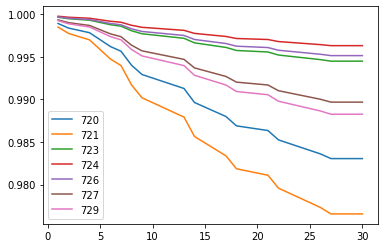

In [95]:
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)#_train, conditional_after=data_urti_no_abs_incdt_train.duration_urti_admitted)
survival_func_plot = cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)
plt.plot(survival_func_plot.loc[:, 720:729])
plt.legend(labels=survival_func_plot.loc[:, 720:729].columns, loc ="lower left")

In [96]:
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt, t0=30)

In [101]:
cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt)

,0,1,8,9,10,11,13,14,15,16,...,7107,7113,7114,7115,7116,7117,7118,7122,7124,7132
1.0,0.000425,0.000128,0.000068,0.000741,0.000172,0.000023,0.000128,0.000101,0.000144,0.000878,...,0.000081,0.000137,0.000851,0.000047,0.000329,0.000041,0.000052,0.000038,0.000066,0.000563
2.0,0.000637,0.000191,0.000103,0.001112,0.000259,0.000034,0.000191,0.000152,0.000215,0.001318,...,0.000122,0.000206,0.001277,0.000071,0.000493,0.000061,0.000079,0.000058,0.000099,0.000845
4.0,0.000851,0.000255,0.000137,0.001485,0.000345,0.000045,0.000255,0.000203,0.000288,0.001760,...,0.000162,0.000275,0.001705,0.000094,0.000658,0.000082,0.000105,0.000077,0.000132,0.001128
6.0,0.001492,0.000448,0.000240,0.002604,0.000606,0.000080,0.000448,0.000356,0.000504,0.003085,...,0.000285,0.000482,0.002990,0.000165,0.001154,0.000144,0.000184,0.000135,0.000232,0.001978
7.0,0.001707,0.000512,0.000275,0.002978,0.000693,0.000091,0.000512,0.000408,0.000577,0.003529,...,0.000326,0.000552,0.003420,0.000189,0.001320,0.000164,0.000211,0.000154,0.000265,0.002262
8.0,0.002353,0.000706,0.000379,0.004105,0.000955,0.000126,0.000706,0.000562,0.000795,0.004864,...,0.000449,0.000760,0.004715,0.000261,0.001820,0.000227,0.000290,0.000213,0.000365,0.003118
9.0,0.002784,0.000836,0.000449,0.004858,0.001130,0.000149,0.000836,0.000665,0.000941,0.005757,...,0.000531,0.000900,0.005580,0.000309,0.002154,0.000268,0.000344,0.000252,0.000432,0.003691
13.0,0.003433,0.001030,0.000553,0.005989,0.001394,0.000183,0.001030,0.000820,0.001160,0.007097,...,0.000655,0.001109,0.006879,0.000381,0.002655,0.000330,0.000423,0.000310,0.000533,0.004550
14.0,0.004084,0.001226,0.000658,0.007126,0.001658,0.000218,0.001226,0.000975,0.001380,0.008444,...,0.000779,0.001320,0.008184,0.000453,0.003159,0.000393,0.000504,0.000369,0.000634,0.005413
15.0,0.004302,0.001291,0.000693,0.007506,0.001746,0.000230,0.001291,0.001027,0.001454,0.008894,...,0.000821,0.001390,0.008620,0.000477,0.003328,0.000414,0.000531,0.000389,0.000668,0.005702


In [100]:
cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)#.min()#.min()

,0,1,8,9,10,11,13,14,15,16,...,7107,7113,7114,7115,7116,7117,7118,7122,7124,7132
1.0,0.999575,0.999873,0.999932,0.999259,0.999828,0.999977,0.999873,0.999899,0.999856,0.999122,...,0.999919,0.999863,0.999149,0.999953,0.999671,0.999959,0.999948,0.999962,0.999934,0.999437
2.0,0.999363,0.999809,0.999897,0.998889,0.999741,0.999966,0.999809,0.999848,0.999785,0.998683,...,0.999878,0.999794,0.998724,0.999929,0.999507,0.999939,0.999921,0.999942,0.999901,0.999156
4.0,0.999149,0.999745,0.999863,0.998516,0.999655,0.999955,0.999745,0.999797,0.999712,0.998242,...,0.999838,0.999725,0.998296,0.999906,0.999342,0.999918,0.999895,0.999923,0.999868,0.998873
6.0,0.998509,0.999552,0.999760,0.997400,0.999394,0.999920,0.999552,0.999644,0.999496,0.996919,...,0.999715,0.999518,0.997014,0.999835,0.998846,0.999856,0.999816,0.999865,0.999768,0.998024
7.0,0.998295,0.999488,0.999725,0.997026,0.999307,0.999909,0.999488,0.999592,0.999423,0.996477,...,0.999674,0.999448,0.996585,0.999811,0.998681,0.999836,0.999789,0.999846,0.999735,0.997740
8.0,0.997650,0.999294,0.999621,0.995904,0.999045,0.999874,0.999294,0.999438,0.999205,0.995148,...,0.999551,0.999240,0.995297,0.999739,0.998182,0.999774,0.999710,0.999787,0.999635,0.996886
9.0,0.997219,0.999165,0.999551,0.995154,0.998870,0.999851,0.999165,0.999335,0.999060,0.994260,...,0.999469,0.999100,0.994436,0.999691,0.997848,0.999732,0.999657,0.999748,0.999568,0.996316
13.0,0.996573,0.998970,0.999447,0.994029,0.998607,0.999817,0.998970,0.999181,0.998841,0.992928,...,0.999345,0.998891,0.993145,0.999619,0.997348,0.999670,0.999577,0.999690,0.999467,0.995460
14.0,0.995924,0.998775,0.999342,0.992900,0.998343,0.999782,0.998775,0.999025,0.998621,0.991592,...,0.999221,0.998681,0.991849,0.999547,0.996846,0.999607,0.999496,0.999631,0.999366,0.994601
15.0,0.995708,0.998710,0.999307,0.992522,0.998255,0.999770,0.998710,0.998973,0.998547,0.991145,...,0.999179,0.998611,0.991417,0.999523,0.996678,0.999586,0.999469,0.999611,0.999333,0.994314


In [89]:
# cph_urti_no_abs_incdt.plot_partial_effects_on_outcome(data_urti_no_abs_incdt.event_urti_admitted, values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [90]:
# data_urti_no_abs_incdt.loc[data_urti_no_abs_incdt.event_urti_admitted == 1]
# survival_func_plot

In [91]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_incdt.txt', a, delimiter=',')

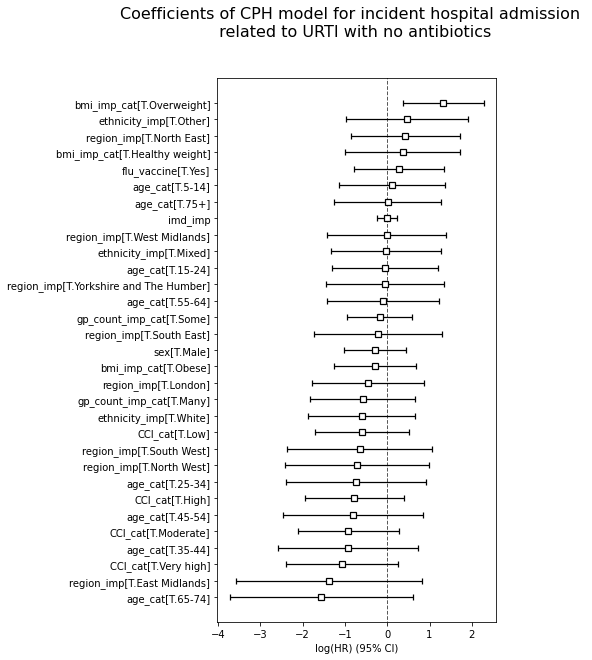

In [92]:
fig, ax = plt.subplots(figsize=(5, 10)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [93]:
# concordance index of cph model with testing data
concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

Concordance index for urti_no_abs_incdt with testing data: 0.6194697529344169


In [94]:
a = [concord_index_urti_no_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

ICI =  0.0004348292627979522
E50 =  0.00031631208516691434


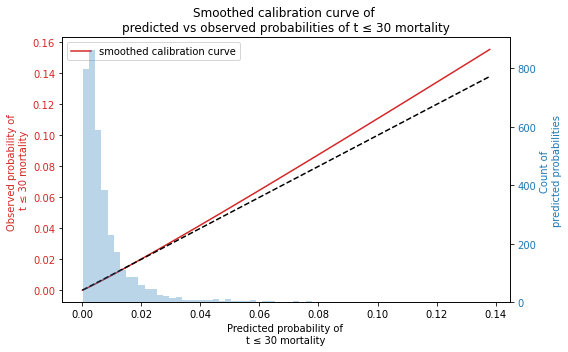

In [95]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

# t0 (float) – the time to evaluate the probability of event occurring prior at.
# ICI – mean absolute difference between predicted and observed
# E50 – median absolute difference between predicted and observed

ICI =  0.004079128504346049
E50 =  0.002926833953712682


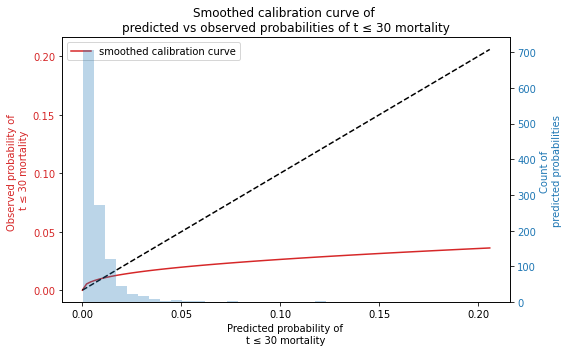

In [96]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [112]:
# print(cph_urti_no_abs_incdt.score(data_urti_no_abs_incdt_1_test))
# print(cph_urti_no_abs_incdt.concordance_index_)
# print(cph_urti_no_abs_incdt.AIC_partial_)
# print(cph_urti_no_abs_incdt.concordance_index_)

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [175]:
data_urti_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [176]:
data_urti_abs_incdt.shape

(560, 40)

In [97]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                           'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                           'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                           'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                           'event_urti_admitted', 'duration_urti_admitted']]

In [98]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [99]:
# #drop ros with missing values
# data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
# #data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
# data_urti_abs_incdt.isnull().sum()

In [100]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_train, data_urti_abs_incdt_test = train_test_split(data_urti_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (420, 20)
shape of data_urti_abs_incdt for testing: (140, 20)


In [101]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 420 total observations, 416 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 4
   partial log-likelihood = -8.58
         time fit was run = 2022-05-05 09:19:52 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                           4.73     113.07      11.33           -17.47            26.93                 0.00             4.94e+11
CCI_cat[T.Moderate]                      0.06       1.06      11.80           -23.07            23.19                 0.00             1.18e+10
CCI_cat[T.High]                          2.25       9.44      11.44           -20.18            24.67                 0.00             5.18e+10
CCI_cat[T.Very high]                    -5.26       0.01      14.87           -34.40            23.88                 0.00             2.35e+10
age_cat[T.15-24]                        -3.33       0.04      10.20           -23.34            16.67                 0.00             1.73e+07
age_cat[T.25-34]                        -2.59       0.08      17.22           -36.34            31.16                 0.00             3.42e+13
age_cat[T.35-44]                        -1.53       0.22      10.12           -21.37            18.31                 0.00             8.92e+07
age_cat[T.45-54]                         5.25     190.01       8.07           -10.57            21.07                 0.00             1.41e+09
age_cat[T.5-14]                         -2.30       0.10      11.60           -25.04            20.44                 0.00             7.52e+08
age_cat[T.55-64]                         4.17      64.74       7.77           -11.06            19.40                 0.00             2.67e+08
age_cat[T.65-74]                         3.93      51.02       7.92           -11.60            19.46                 0.00             2.84e+08
age_cat[T.75+]                           2.04       7.73       7.93           -13.50            17.59                 0.00             4.36e+07
bmi_imp_cat[T.Healthy weight]            3.67      39.43       4.98            -6.08            13.43                 0.00             6.79e+05
bmi_imp_cat[T.Overweight]               -2.58       0.08       7.68           -17.62            12.47                 0.00             2.60e+05
bmi_imp_cat[T.Obese]                     0.43       1.54       3.19            -5.81             6.68                 0.00               797.93
ethnicity_imp[T.Mixed]                   5.76     316.74       7.03            -8.01            19.53                 0.00             3.03e+08
ethnicity_imp[T.Other]                   5.83     340.53      21.86           -37.02            48.68                 0.00             1.38e+21
ethnicity_imp[T.White]                   4.23      68.72       7.19            -9.87            18.33                 0.00             9.13e+07
flu_vaccine[T.Yes]                       4.16      63.98       4.00            -3.68            12.00                 0.03             1.62e+05
gp_count_imp_cat[T.Some]                -9.56       0.00       7.13           -23.55             4.42                 0.00                83.04
gp_count_imp_cat[T.Many]                -1.09       0.34       2.45            -5.88             3.71                 0.00                40.81
imd_imp                                  0.48       1.62       1.00            -1.49             2.45                 0.23                11.63
region_imp[T.East Midlands]             -9.24       0.00      28.02           -64.16            45.69                 0.00             6.93e+19
region_imp[T.Lo

In [182]:
output = GetPrintSummary(cph_urti_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

10231


In [183]:
a = cph_urti_abs_incdt.baseline_hazard_
# cph_urti_abs_incdt.baseline_survival_
# cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt, data_urti_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_abs_incdt.predict_survival_function(data_urti_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_incdt.txt', a, delimiter=',')

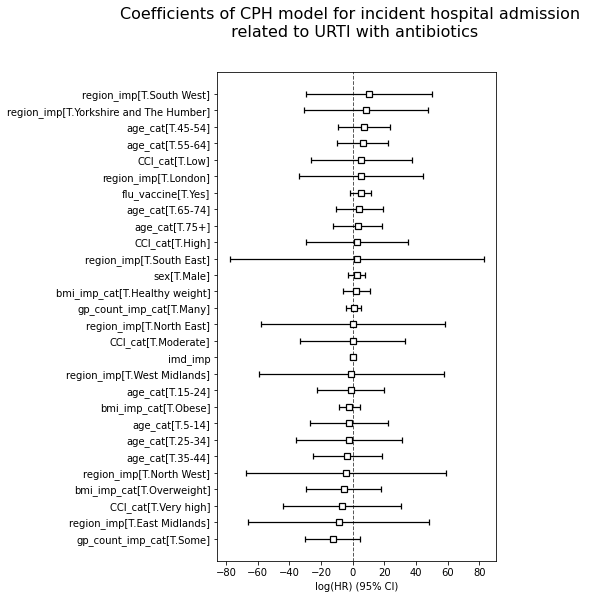

In [184]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [185]:
# concordance index of cph model with testing data
concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

Concordance index for urti_abs_incdt with testing data: 0.37410071942446044


In [123]:
a = [concord_index_urti_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

ICI =  0.010121532334821657
E50 =  4.3300513175026367e-10


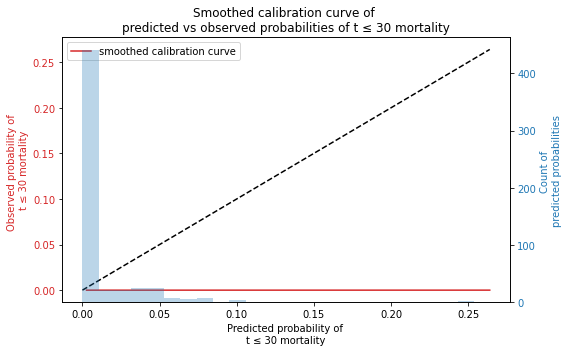

In [165]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

ICI =  0.013762422725908805
E50 =  2.145939259623475e-09


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 30 mortality'}, xlabel='Predicted probability of \nt ≤ 30 mortality', ylabel='Observed probability of \nt ≤ 30 mortality'>,
 0.013762422725908805,
 2.145939259623475e-09)

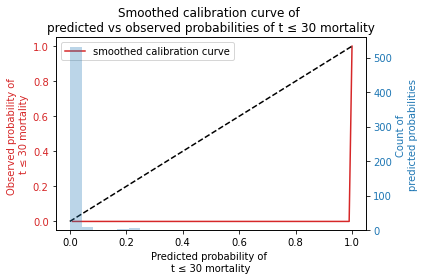

In [189]:
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt, t0=30)

ICI =  0.00986652459255793
E50 =  3.8355557063773915e-09


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 30 mortality'}, xlabel='Predicted probability of \nt ≤ 30 mortality', ylabel='Observed probability of \nt ≤ 30 mortality'>,
 0.00986652459255793,
 3.8355557063773915e-09)

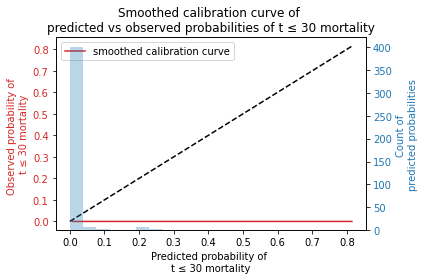

In [190]:
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)

In [126]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [127]:
data_urti_no_abs_prevl.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [128]:
data_urti_no_abs_prevl.shape

(554, 40)

In [129]:
#keep relevant variables
data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                                 'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [130]:
# printing number of missing values in each variable 
data_urti_no_abs_prevl.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [132]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = train_test_split(data_urti_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

shape of data_urti_no_abs_prevl for training: (415, 20)
shape of data_urti_no_abs_prevl for testing: (139, 20)


In [133]:
cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        )
cph_urti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 415 total observations, 412 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 415
number of events observed = 3
   partial log-likelihood = -12.56
         time fit was run = 2022-04-28 19:42:36 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
CCI_cat[T.Low]            17.34   3.38e+07   12063.06        -23625.82         23660.50                 0.00                  inf
CCI_cat[T.Moderate]       17.55   4.20e+07   12063.06        -23625.61         23660.72                 0.00                  inf
CCI_cat[T.High]           17.61   4.47e+07   12063.06        -23625.55         23660.78                 0.00                  inf
CCI_cat[T.Very high]      -0.05       0.95   14199.85        -27831.25         27831.14                 0.00                  inf
age_cat[T.15-24]          -0.32       0.72   18982.08        -37204.51         37203.87                 0.00                  inf
age_cat[T.25-34]          -0.90       0.41   21043.47        -41245.35         41243.54                 0.00                  inf
age_cat[T.35-44]          -0.76       0.47   19671.10        -38555.41         38553.89                 0.00                  inf
age_cat[T.45-54]          -0.52       0.60   19640.29        -38494.77         38493.74                 0.00                  inf
age_cat[T.5-14]           18.01   6.63e+07   14375.47        -28157.38         28193.41                 0.00                  inf
age_cat[T.55-64]          -0.25       0.78   19048.04        -37333.73         37333.23                 0.00                  inf
age_cat[T.65-74]          18.42   9.99e+07   14375.47        -28156.98         28193.81                 0.00                  inf
age_cat[T.75+]            18.07   7.03e+07   14375.47        -28157.33         28193.46                 0.00                  inf
flu_vaccine[T.Yes]       -17.69       0.00   10429.64        -20459.40         20424.02                 0.00                  inf
gp_count_imp_cat[T.Some] -17.54       0.00    5478.31        -10754.83         10719.75                 0.00                  inf
gp_count_imp_cat[T.Many]   0.06       1.07       1.26            -2.40             2.53                 0.09                12.52
sex[T.Male]               -0.56       0.57       1.25            -3.01             1.89                 0.05                 6.61

                           cmp to     z    p   -log2(p)
covariate                                              
CCI_cat[T.Low]               0.00  0.00 1.00       0.00
CCI_cat[T.Moderate]          0.00  0.00 1.00       0.00
CCI_cat[T.High]              0.00  0.00 1.00       0.00
CCI_cat[T.Very high]         0.00 -0.00 1.00       0.00
age_cat[T.15-24]             0.00 -0.00 1.00       0.00
age_cat[T.25-34]             0.00 -0.00 1.00       0.00
age_cat[T.35-44]             0.00 -0.00 1.00       0.00
age_cat[T.45-54]             0.00 -0.00 1.00       0.00
age_cat[T.5-14]              0.00  0.00 1.00       0.00
age_cat[T.55-64]             0.00 -0.00 1.00       0.00
age_cat[T.65-74]             0.00  0.00 1.00       0.00
age_cat[T.75+]               0.00  0.00 1.00       0.00
flu_vaccine[T.Yes]           0.00 -0.00 1.00       0.00
gp_count_imp_cat[T.Some]     0.00 -0.00 1.00       0.00
gp_count_imp_cat[T.Many]     0.00  0.05 0.96       0.06
sex[T.Male]                  0.00 -0.45 0.65       0.61
---
Concordance = 0.93
Partial AIC = 57.11
log-likelihood ratio test = 11.04 on 16 df
-log2(p) of ll-ratio test = 0.31

In [134]:
output = GetPrintSummary(cph_urti_no_abs_prevl)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

6866


In [135]:
a = cph_urti_no_abs_prevl.baseline_hazard_
# cph_urti_no_abs_prevl.baseline_survival_
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_prevl.txt', a, delimiter=',')

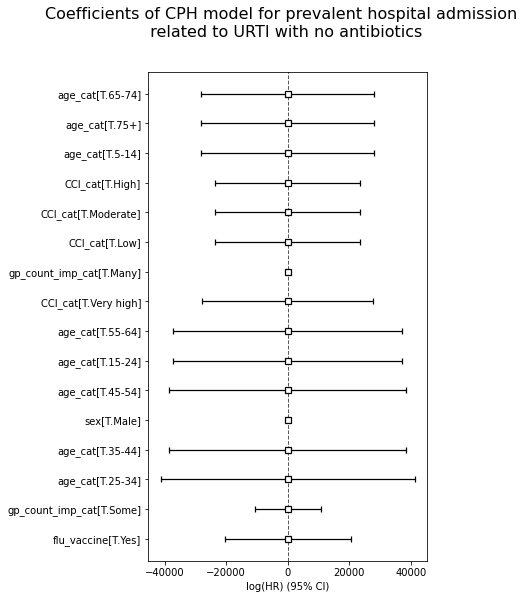

In [136]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [137]:
# data_urti_no_abs_prevl_test.columns

In [141]:
# concordance index of cph model with testing data
concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

Concordance index for cph_urti_no_abs_prevl with testing data: 0.12318840579710146


In [145]:
a = [concord_index_urti_no_abs_prevl_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

ICI =  0.007171901710415653
E50 =  3.9823433439778455e-10


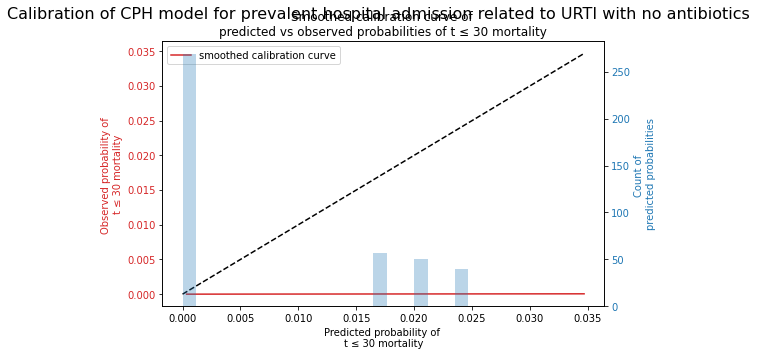

In [146]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [148]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [147]:
data_urti_abs_prevl.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [148]:
#keep relevant variables
data_urti_abs_prevl = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                           'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                           'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                           'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                           'event_urti_admitted', 'duration_urti_admitted']]

In [149]:
# print number of missing values in each variable 
data_urti_abs_prevl.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [150]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_prevl_train, data_urti_abs_prevl_test = train_test_split(data_urti_abs_prevl, test_size=0.2)

print(f'shape of data_urti_abs_prevl for training: {data_urti_abs_prevl_train.shape}')
print(f'shape of data_urti_abs_prevl for testing: {data_urti_abs_prevl_test.shape}')

shape of data_urti_abs_prevl for training: (48, 20)
shape of data_urti_abs_prevl for testing: (12, 20)


In [151]:
cph_urti_abs_prevl = CoxPHFitter().fit(data_urti_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        )
cph_urti_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 48 total observations, 47 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 48
number of events observed = 1
   partial log-likelihood = -0.69
         time fit was run = 2022-04-28 20:10:14 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
CCI_cat[T.Low]             0.45       1.56   14701.44        -28813.84         28814.74                 0.00                  inf
CCI_cat[T.Moderate]        1.06       2.88   13366.10        -26196.01         26198.13                 0.00                  inf
CCI_cat[T.High]           -3.68       0.03   18754.05        -36760.94         36753.59                 0.00                  inf
CCI_cat[T.Very high]      10.68   43314.67   23710.37        -46460.79         46482.14                 0.00                  inf
age_cat[T.15-24]         -16.89       0.00    6571.00        -12895.80         12862.03                 0.00                  inf
age_cat[T.25-34]         -10.33       0.00   23996.62        -47042.84         47022.18                 0.00                  inf
age_cat[T.35-44]          -3.72       0.02   43114.61        -84506.81         84499.36                 0.00                  inf
age_cat[T.45-54]          -6.29       0.00   19851.11        -38913.75         38901.17                 0.00                  inf
age_cat[T.5-14]          -10.26       0.00   23251.76        -45582.87         45562.35                 0.00                  inf
age_cat[T.55-64]         -17.36       0.00    8341.64        -16366.68         16331.95                 0.00                  inf
age_cat[T.65-74]          -4.94       0.01   14261.62        -27957.20         27947.32                 0.00                  inf
age_cat[T.75+]            -9.69       0.00   23015.35        -45118.95         45099.57                 0.00                  inf
flu_vaccine[T.Yes]        -4.93       0.01   35687.64        -69951.42         69941.55                 0.00                  inf
gp_count_imp_cat[T.Some]  -7.46       0.00   21887.85        -42906.86         42891.94                 0.00                  inf
gp_count_imp_cat[T.Many]  -2.72       0.07   15151.38        -29698.87         29693.43                 0.00                  inf
sex[T.Male]               -7.33       0.00   20724.21        -40626.03         40611.36                 0.00                  inf

                           cmp to     z    p   -log2(p)
covariate                                              
CCI_cat[T.Low]               0.00  0.00 1.00       0.00
CCI_cat[T.Moderate]          0.00  0.00 1.00       0.00
CCI_cat[T.High]              0.00 -0.00 1.00       0.00
CCI_cat[T.Very high]         0.00  0.00 1.00       0.00
age_cat[T.15-24]             0.00 -0.00 1.00       0.00
age_cat[T.25-34]             0.00 -0.00 1.00       0.00
age_cat[T.35-44]             0.00 -0.00 1.00       0.00
age_cat[T.45-54]             0.00 -0.00 1.00       0.00
age_cat[T.5-14]              0.00 -0.00 1.00       0.00
age_cat[T.55-64]             0.00 -0.00 1.00       0.00
age_cat[T.65-74]             0.00 -0.00 1.00       0.00
age_cat[T.75+]               0.00 -0.00 1.00       0.00
flu_vaccine[T.Yes]           0.00 -0.00 1.00       0.00
gp_count_imp_cat[T.Some]     0.00 -0.00 1.00       0.00
gp_count_imp_cat[T.Many]     0.00 -0.00 1.00       0.00
sex[T.Male]                  0.00 -0.00 1.00       0.00
---
Concordance = 0.99
Partial AIC = 33.39
log-likelihood ratio test = 6.36 on 16 df
-log2(p) of ll-ratio test = 0.02

In [152]:
output = GetPrintSummary(cph_urti_abs_prevl)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

6868


In [153]:
a = cph_urti_abs_prevl.baseline_hazard_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_prevl.txt', a, delimiter=',')

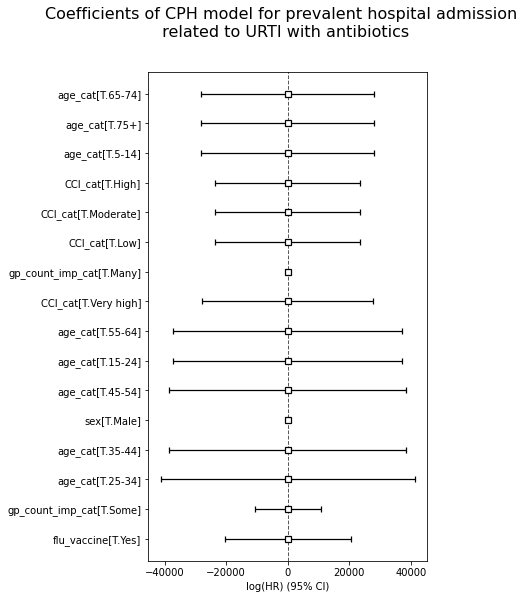

In [154]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [156]:
# concordance index of cph model with testing data
concord_index_urti_abs_prevl_test = concordance_index(data_urti_abs_prevl_test['duration_urti_admitted'], -cph_urti_abs_prevl.predict_partial_hazard(data_urti_abs_prevl_test), data_urti_abs_prevl_test['event_urti_admitted'])
print(f'Concordance index for cph_urti_abs_prevl with testing data: {concord_index_urti_abs_prevl_test}')

In [ ]:
a = [concord_index_urti_abs_prevl_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_prevl_test.txt', a, delimiter=',')

In [147]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_train, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()